# Neural Network Classification with Python

Classification is a problem of predicting whether something is one thing or another.


In [1]:
## Make classification data

from sklearn.datasets import make_circles

n_samples = 1000

# Create samples

X, y = make_circles(n_samples, noise=0.03, random_state=42)



In [2]:
len(X), len(y)

(1000, 1000)

In [3]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [4]:
# MAke DF of circle data

import pandas as pd

circles = pd.DataFrame({"X1": X[:,0],
                        "X2": X[:,1],
                        "label": y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


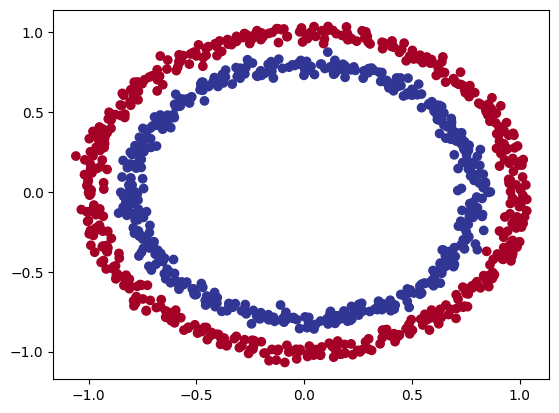

In [5]:
# Viz, viz, viz

import matplotlib.pyplot as plt

plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

Note: The data we're working with is often reffered to as a toy dataset, a dataset that is small enough to experiment but still sizeable enough to practice the fundementals

### 1.1 Check input and output shapes



In [6]:
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
# View the first example of features and labels

X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [8]:
import torch
torch.__version__

'2.4.1+cu121'

In [9]:
type(X)

numpy.ndarray

In [10]:
# Turn ddata into tensors

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [11]:
type(X)

torch.Tensor

In [12]:
# Split data into training and test set

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [13]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Build a model to classify our blue and red dots

1. Setup agnostic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model
3. Define loss function and optimizer
4. Create training and testing loop

In [14]:
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Create a model:

1. Subclass `nn.Module`
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method that outlines the forward pass of our model
4. Instantiate an instance of our model class and send it to the target `divice`


In [15]:
# 1. Construct a model

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear() layers capable of handling shapes our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # Takes in 2 features(Shape of X_train) and upscales (more features more learning) to 5 features
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # Takes in 5 features from previous layer and outputs a single layer

    # 3. Define a forward method that outlines the forward pass of our model
    def forward(self, x):
      return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
next(model_0.parameters()).device

device(type='cpu')

In [17]:
# Replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0031,  0.3118],
                      [ 0.3794,  0.2542],
                      [ 0.6664, -0.5510],
                      [-0.3143, -0.2155],
                      [-0.2400,  0.0575]])),
             ('0.bias', tensor([ 0.4430,  0.2076, -0.0466,  0.5193,  0.5632])),
             ('1.weight',
              tensor([[-0.0733, -0.0913,  0.2084, -0.3864, -0.2483]])),
             ('1.bias', tensor([-0.0371]))])

In [19]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-1.],
        [-1.],
        [-1.],
        [-1.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-1.],
        [-1.]])

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup Loss Functiın and Optimizer

For classification you might want binary cross entopy or categorical cross entropy.

As a reminder, the loss function measures how wrong your models predictions are.

* For the loss function we're going to use `torch.nn.BECWithLogitsLoss()`

In [20]:
# Setup the loss functiın
loss_fn = nn.BCEWithLogitsLoss() # sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [21]:
# Calculate accuracy - out of 100 examples, what percentage does our model ge right?

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

## 3. Train model

Trainin loop:

1. Forward pass
2. Calc. the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**.

We can convert this logits into prediction probabilities by passing them to some kind of activation function. (e.g sigmoid for binary classification and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or takinf the `argmax()`

In [22]:
# View the first 5 outputs of the forwards pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.6085],
        [-0.5225],
        [-0.6104],
        [-0.6089],
        [-0.2555]])

In [23]:
# Use the sigmoid activatiın function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)

y_pred_probs

tensor([[0.3524],
        [0.3723],
        [0.3520],
        [0.3523],
        [0.4365]])

For our prediction probability values, we need to perform a range-style rounding on them:
- `y_pred_probs` >= 0.5 `y=1` (class 1)
- `y_pred_probs` < 0.5 `y=0` (class 0)

In [24]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)
# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))
# Get rid of extra dim
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 0.])

### 3.2 Building the training and testing

In [25]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

#Build training and evaluation loop
for epoch in range(epochs):
  ## Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  # 2. Calculate loss/accuracy
  # loss = loss_fn(torch.sigmoid(y_logits), # nn.BCELoss expects prediction probabilities as input
  #                 y_train)
  loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss expects raw logits as input
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred = y_pred)

  # 3. Optimize zero grad
  optimizer.zero_grad()

  # 4. Loss backward (Backpropagation)
  loss.backward()

  # 5. Optimizer step (Gradient Descent)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1.Forward pass
    test_logits = model_0(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate the test loss/acc
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred = test_preds)

    # Print out what's happenin'
    if epoch % 10 ==0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.72119, Acc: 50.00% | Test Loss: 0.72000, Test Acc: 50.00%
Epoch: 10 | Loss: 0.70435, Acc: 49.62% | Test Loss: 0.70473, Test Acc: 49.00%
Epoch: 20 | Loss: 0.69821, Acc: 44.00% | Test Loss: 0.69916, Test Acc: 44.50%
Epoch: 30 | Loss: 0.69577, Acc: 48.62% | Test Loss: 0.69697, Test Acc: 45.00%
Epoch: 40 | Loss: 0.69471, Acc: 49.88% | Test Loss: 0.69605, Test Acc: 46.00%
Epoch: 50 | Loss: 0.69419, Acc: 49.38% | Test Loss: 0.69561, Test Acc: 49.50%
Epoch: 60 | Loss: 0.69389, Acc: 49.25% | Test Loss: 0.69538, Test Acc: 49.50%
Epoch: 70 | Loss: 0.69370, Acc: 49.38% | Test Loss: 0.69524, Test Acc: 50.50%
Epoch: 80 | Loss: 0.69357, Acc: 49.62% | Test Loss: 0.69514, Test Acc: 49.00%
Epoch: 90 | Loss: 0.69346, Acc: 50.50% | Test Loss: 0.69507, Test Acc: 49.50%


## Make predictions and evaluate the model | Viz, Viz, Viz



In [26]:
import requests
from pathlib import Path

# Download helper functions from Learn Pytorch Repo (if it's not already downloaded)

if Path('helper_functions.py').is_file():
  print('helper_functions.py already exists, skipping downloading')
else:
  print('Downloading')
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


helper_functions.py already exists, skipping downloading


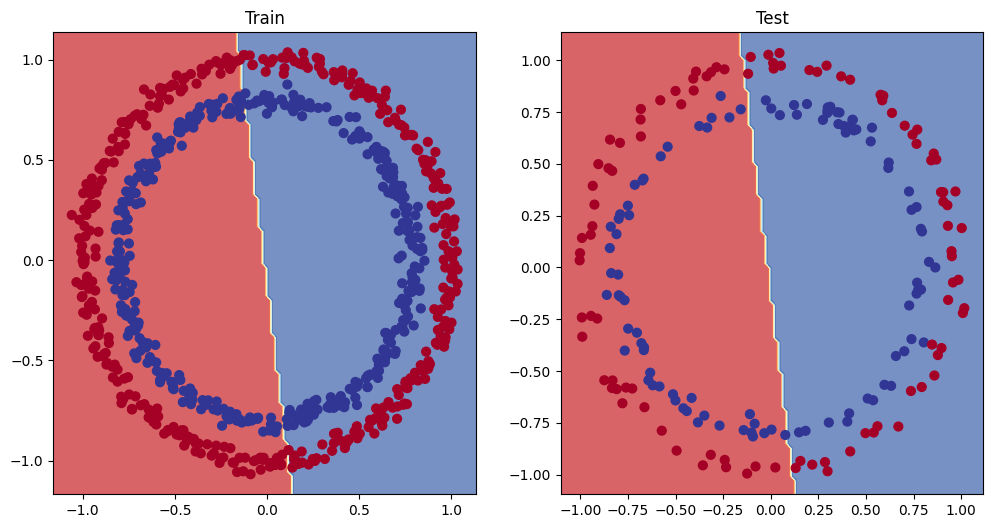

In [27]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)


## 5. Improving our model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data

* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer - more epochs
* Changing the activation functions
* Change the learning rate
* Change the loss function

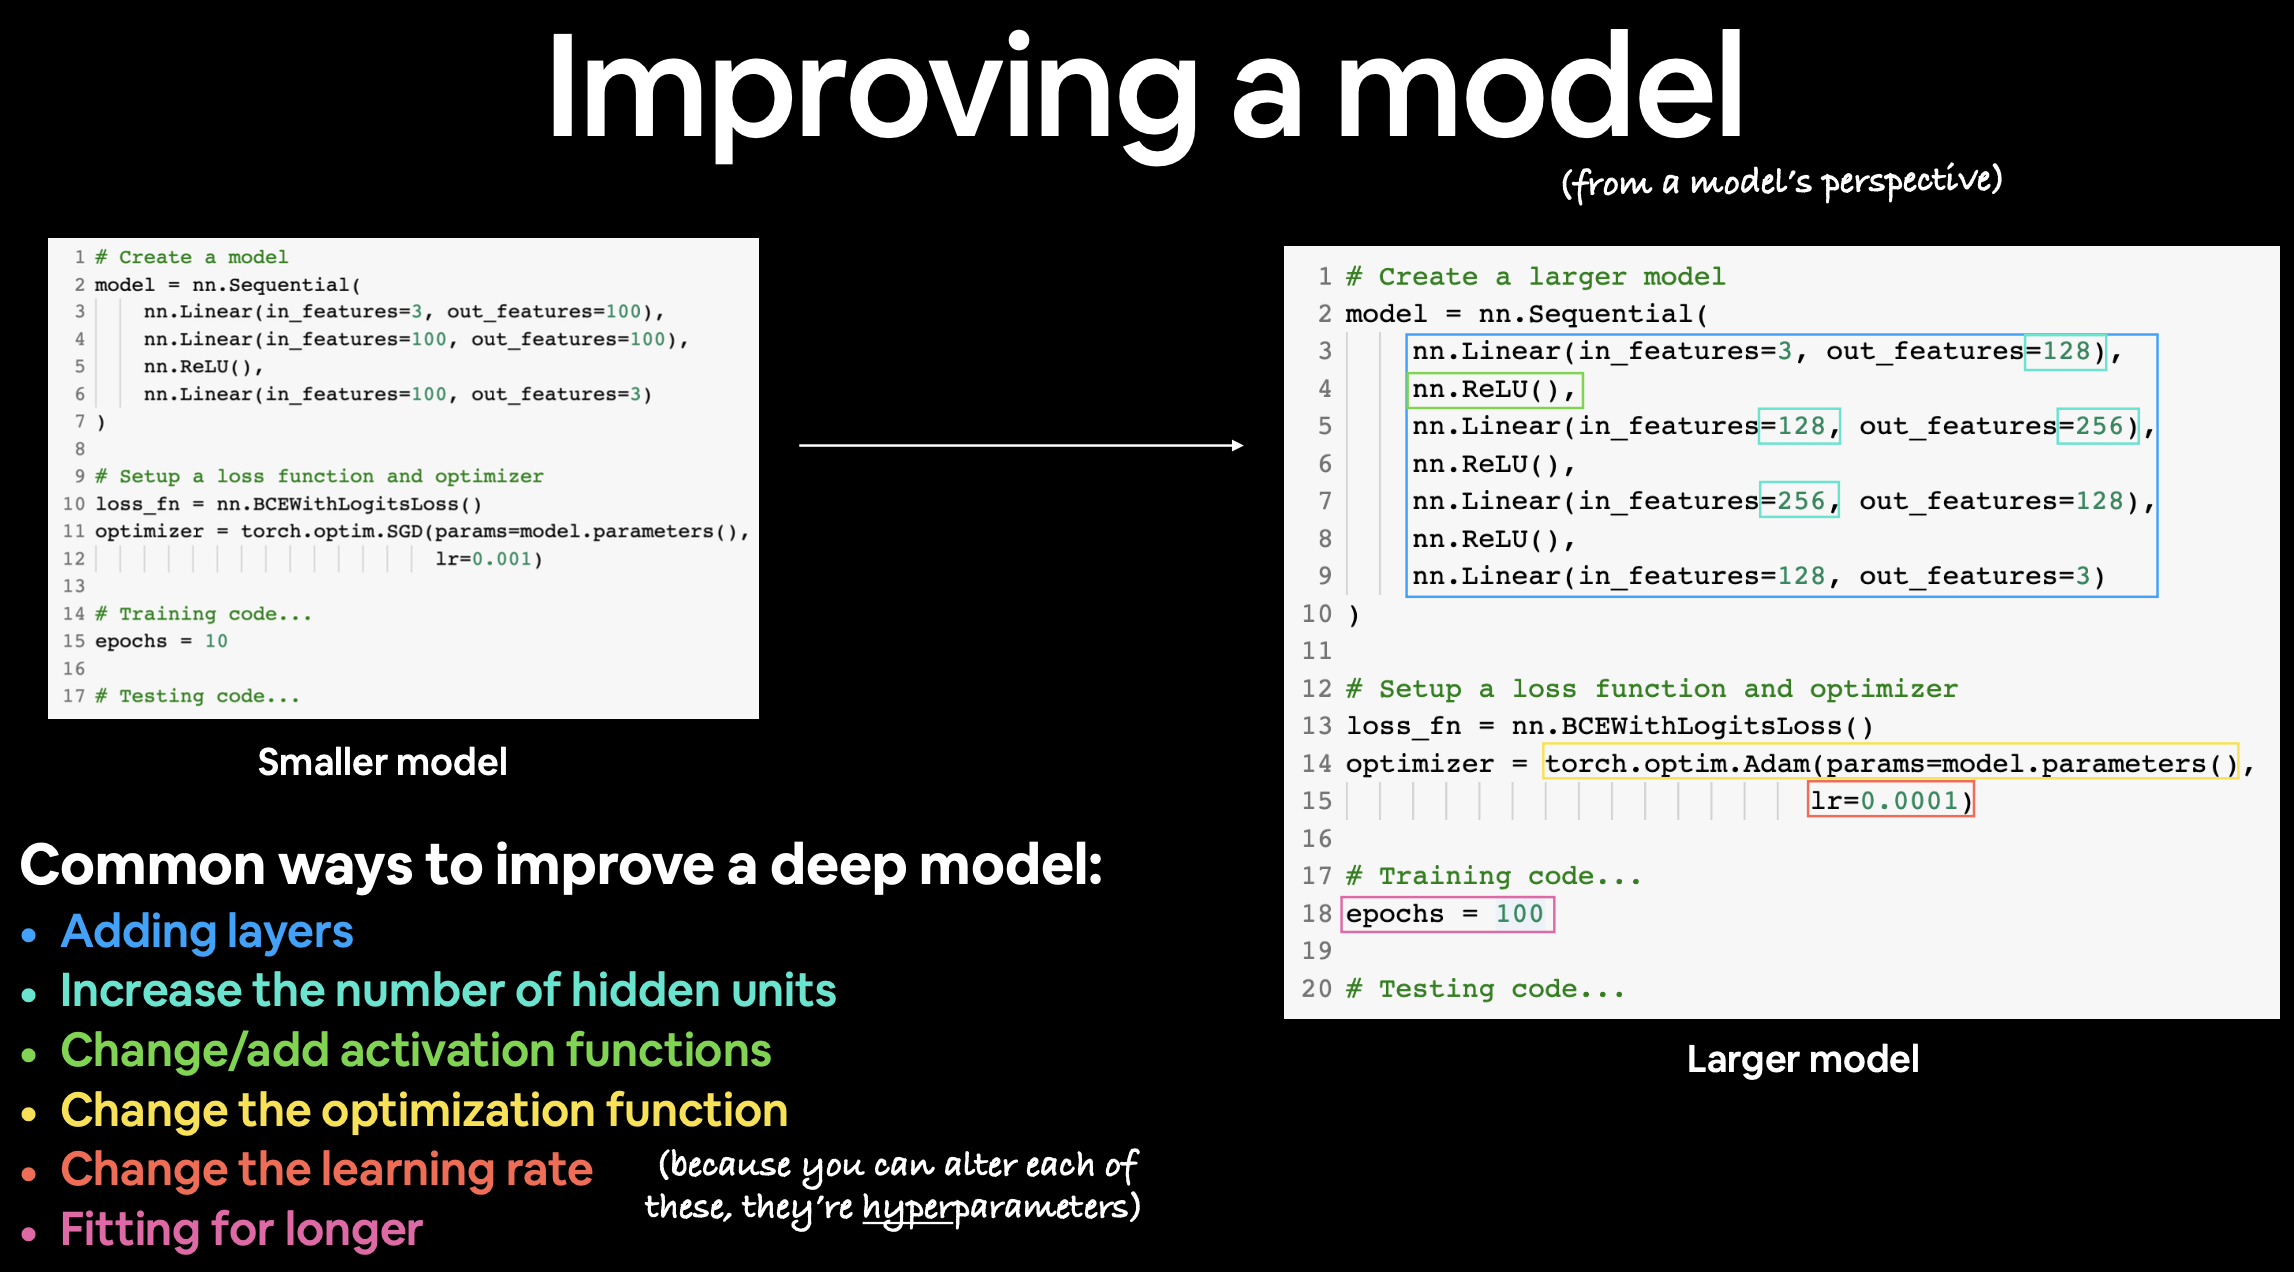

These options are all from a model's perspective because they deal directly with the model, rather than the data.

And because these options are all values we can change , they are referred as **hyperparameteres**

In [28]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)

model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [29]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [30]:
# Write a traning and evaluation loop for model_1

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_1.train()
  # Forwards
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  # Calculate the loss
  loss = loss_fn(y_logits,
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred = y_pred)
  # Optimizer zero grad
  optimizer.zero_grad()
  #Loss backwards
  loss.backward()
  # Optimizer step
  optimizer.step()

  ## Testing
  model_1.eval()
  with torch.inference_mode():
    # Forward pass
    test_logits = model_1(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    # Calculate the loss
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_preds)

  if epoch % 100 ==0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 0.69396, Acc: 50.88% | Test Loss: 0.69261, Test Acc: 51.00%
Epoch: 100 | Loss: 0.69305, Acc: 50.38% | Test Loss: 0.69379, Test Acc: 48.00%
Epoch: 200 | Loss: 0.69299, Acc: 51.12% | Test Loss: 0.69437, Test Acc: 46.00%
Epoch: 300 | Loss: 0.69298, Acc: 51.62% | Test Loss: 0.69458, Test Acc: 45.00%
Epoch: 400 | Loss: 0.69298, Acc: 51.12% | Test Loss: 0.69465, Test Acc: 46.00%
Epoch: 500 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69467, Test Acc: 46.00%
Epoch: 600 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69468, Test Acc: 46.00%
Epoch: 700 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69468, Test Acc: 46.00%
Epoch: 800 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69468, Test Acc: 46.00%
Epoch: 900 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69468, Test Acc: 46.00%


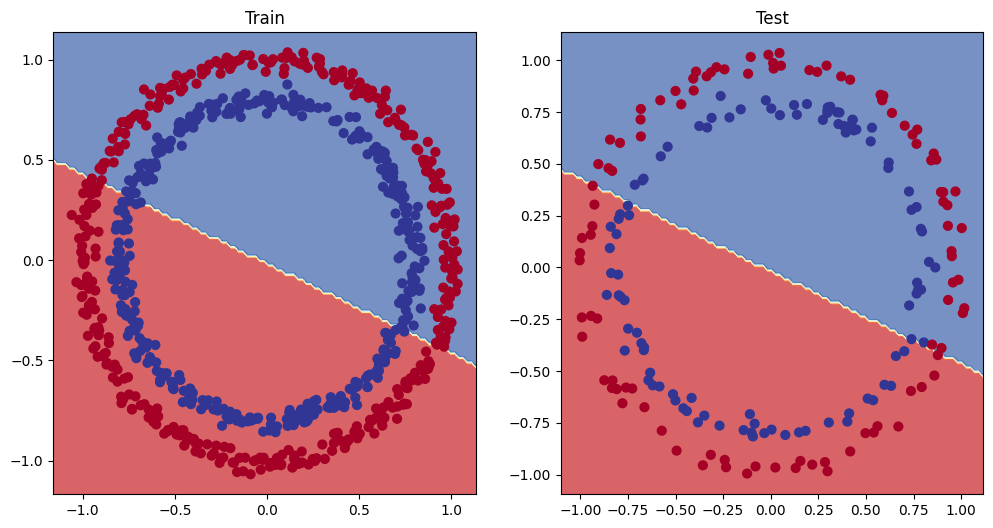

In [31]:
# Plot the decision boundary
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot to a larger problem is to test out a smaller problem

In [32]:
# Create some data
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start,end,step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [33]:
# Create train and test splits
train_split = int(0.8*len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

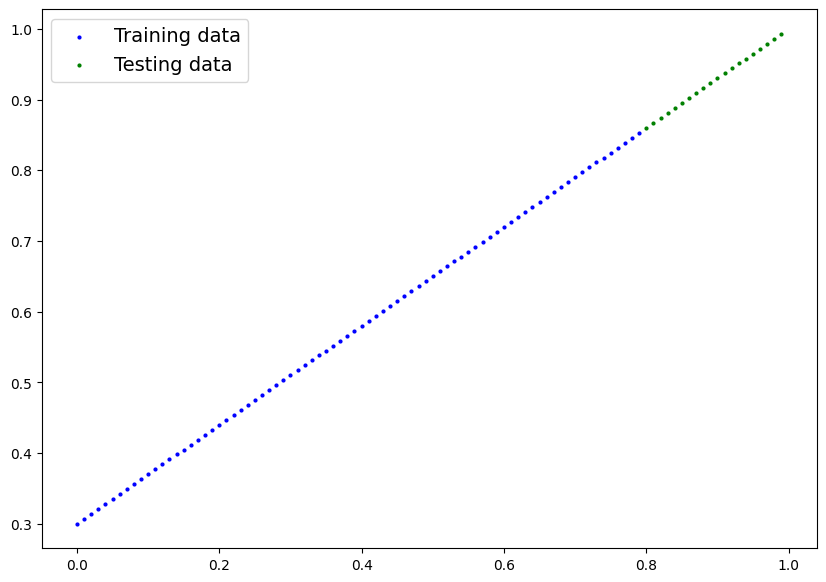

In [34]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data = X_test_regression,
                 test_labels= y_test_regression)

In [35]:
y_train_regression[:2]

tensor([[0.3000],
        [0.3070]])

In [36]:
X_train_regression[:2]

tensor([[0.0000],
        [0.0100]])

### 5.2 Adjust `model_1` to fit a straight line



In [37]:
# Same architecture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [38]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params= model_2.parameters(),
                            lr=0.01)

In [39]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Set the number of epochs
epochs = 1000

#Put the data on target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Train
for epoch in range(epochs):
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred,y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  #Testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

  if epoch %100 ==0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}| Test Loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.75986| Test Loss: 0.91103
Epoch: 100 | Loss: 0.02858| Test Loss: 0.00081
Epoch: 200 | Loss: 0.02533| Test Loss: 0.00209
Epoch: 300 | Loss: 0.02137| Test Loss: 0.00305
Epoch: 400 | Loss: 0.01964| Test Loss: 0.00341
Epoch: 500 | Loss: 0.01940| Test Loss: 0.00387
Epoch: 600 | Loss: 0.01903| Test Loss: 0.00379
Epoch: 700 | Loss: 0.01878| Test Loss: 0.00381
Epoch: 800 | Loss: 0.01840| Test Loss: 0.00329
Epoch: 900 | Loss: 0.01798| Test Loss: 0.00360


Loss decreasing so we can say that our model must be learning sth.

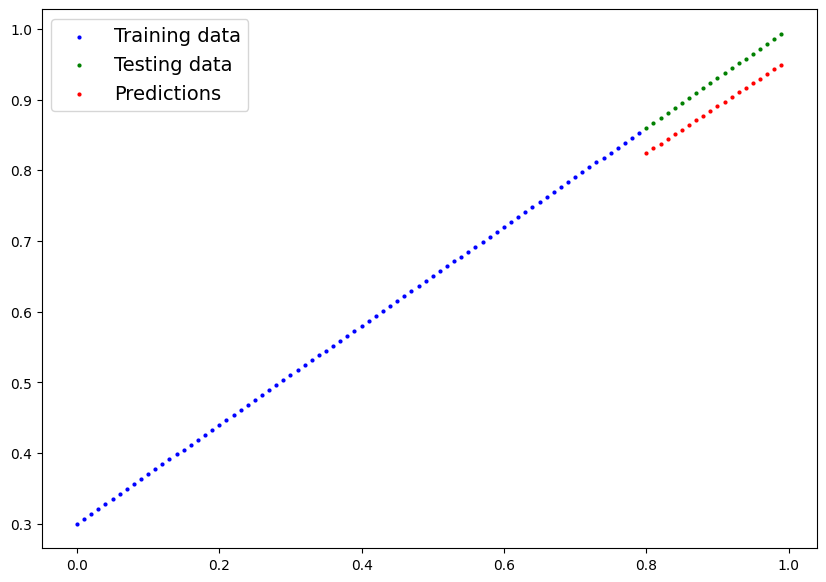

In [40]:
# Turn on evaluation mode
model_2.eval()

# Make predictions
with torch.inference_mode():
  y_preds = model_2(X_test_regression)

# Plot data and predictions
plot_predictions(train_data = X_train_regression.cpu(),
                 train_labels= y_train_regression.cpu(),
                 test_data = X_test_regression.cpu(),
                 test_labels= y_test_regression.cpu(),
                 predictions=y_preds.cpu())

## 6. Missing piece of: Non-Linearity

What patterns could you draw if you were given an infinite amount of a straight and non-straight lines?

Or in ML terms, an infinite (but actually it is finite) of linear and non-linear functions?

### 6.1 Recreating non-linear data (red and blue circles)

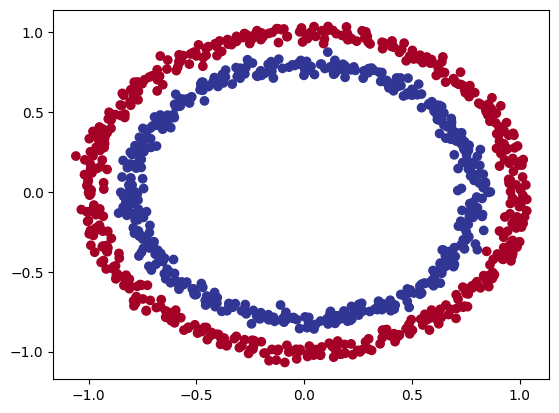

In [41]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu)

In [42]:
# Convert data to tensors and then to train/test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state= 42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity


In [43]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self,x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [44]:
# Loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params= model_3.parameters(),
                            lr=0.1)

In [45]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
#Set the number of epochs
epochs = 1000

for epoch in range(epochs):
  # Training
  model_3.train()
  # Forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # Calculate the loss
  loss = loss_fn(y_logits, y_train) #BCEWithLogitLoss takes logits as first
  acc = accuracy_fn(y_true=y_train,
                    y_pred = y_pred)
  # Optimizer zero grad
  optimizer.zero_grad()
  # Loss backward
  loss.backward()
  # Step the optimizer
  optimizer.step()

  ### Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred= test_pred)

  if epoch % 100==0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.6929, Acc: 50.00% | Test Loss: 0.6932, Acc: 50.00%
Epoch: 100 | Loss: 0.6912, Acc: 52.88% | Test Loss: 0.6910, Acc: 52.50%
Epoch: 200 | Loss: 0.6898, Acc: 53.37% | Test Loss: 0.6894, Acc: 55.00%
Epoch: 300 | Loss: 0.6879, Acc: 53.00% | Test Loss: 0.6872, Acc: 56.00%
Epoch: 400 | Loss: 0.6852, Acc: 52.75% | Test Loss: 0.6841, Acc: 56.50%
Epoch: 500 | Loss: 0.6810, Acc: 52.75% | Test Loss: 0.6794, Acc: 56.50%
Epoch: 600 | Loss: 0.6751, Acc: 54.50% | Test Loss: 0.6729, Acc: 56.00%
Epoch: 700 | Loss: 0.6666, Acc: 58.38% | Test Loss: 0.6632, Acc: 59.00%
Epoch: 800 | Loss: 0.6516, Acc: 64.00% | Test Loss: 0.6476, Acc: 67.50%
Epoch: 900 | Loss: 0.6236, Acc: 74.00% | Test Loss: 0.6215, Acc: 79.00%


### 6.4 Evaluating a model trained with non-linear activation functions

In [46]:
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

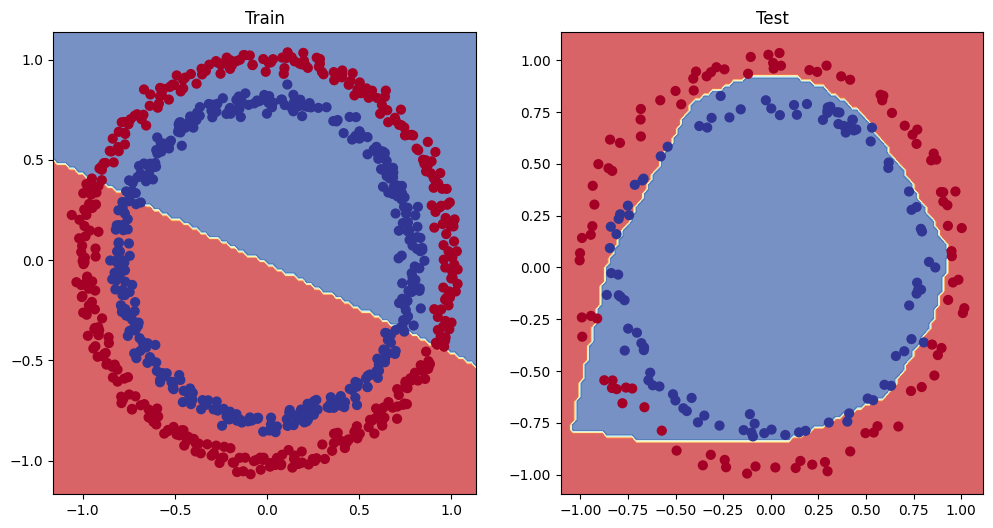

In [47]:
# Plot decision boundaries
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

**Challange:** Can you improve model_3 to do better than 80% accuracy on the test data?

In [48]:
# Lower learning rate
optimizer = torch.optim.SGD(params= model_3.parameters(),
                            lr=0.01)

In [49]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
#Set the number of epochs
epochs = 1000

for epoch in range(epochs):
  # Training
  model_3.train()
  # Forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # Calculate the loss
  loss = loss_fn(y_logits, y_train) #BCEWithLogitLoss takes logits as first
  acc = accuracy_fn(y_true=y_train,
                    y_pred = y_pred)
  # Optimizer zero grad
  optimizer.zero_grad()
  # Loss backward
  loss.backward()
  # Step the optimizer
  optimizer.step()

  ### Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred= test_pred)

  if epoch % 100==0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.5682, Acc: 87.75% | Test Loss: 0.5743, Acc: 86.50%
Epoch: 100 | Loss: 0.5608, Acc: 88.50% | Test Loss: 0.5680, Acc: 88.00%
Epoch: 200 | Loss: 0.5531, Acc: 89.25% | Test Loss: 0.5614, Acc: 89.00%
Epoch: 300 | Loss: 0.5452, Acc: 90.00% | Test Loss: 0.5546, Acc: 89.50%
Epoch: 400 | Loss: 0.5369, Acc: 90.75% | Test Loss: 0.5475, Acc: 89.50%
Epoch: 500 | Loss: 0.5284, Acc: 91.38% | Test Loss: 0.5401, Acc: 89.50%
Epoch: 600 | Loss: 0.5197, Acc: 92.38% | Test Loss: 0.5326, Acc: 89.50%
Epoch: 700 | Loss: 0.5105, Acc: 92.75% | Test Loss: 0.5248, Acc: 90.00%
Epoch: 800 | Loss: 0.5011, Acc: 93.12% | Test Loss: 0.5166, Acc: 90.00%
Epoch: 900 | Loss: 0.4914, Acc: 93.50% | Test Loss: 0.5083, Acc: 89.50%


In [50]:
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

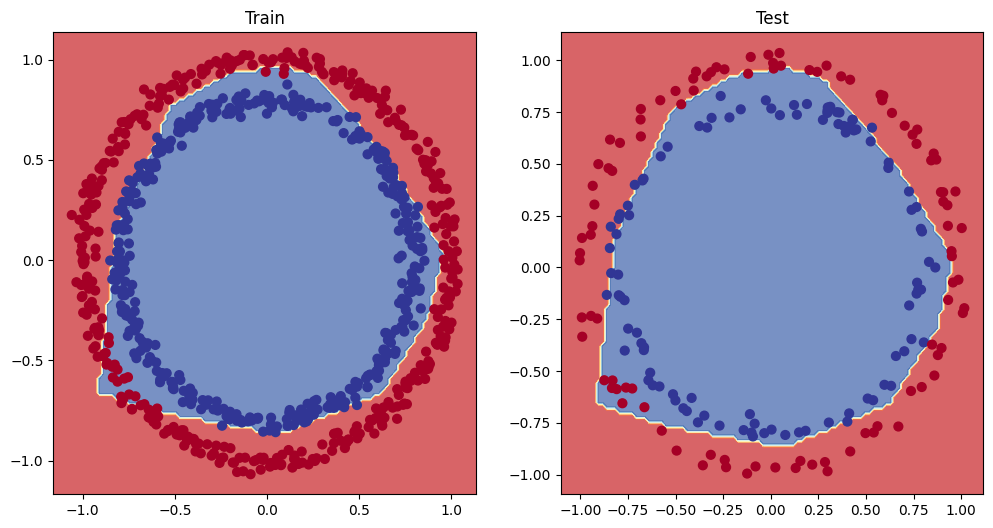

In [51]:
# Plot decision boundaries
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## 7. Replicating non-linear activation functions

NN, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns  on its own.

And these tools are linear&non-linear functions.

In [52]:
# Create a tensor
A = torch.arange(-10,10,1, dtype=torch.float32)
A.dtype

torch.float32

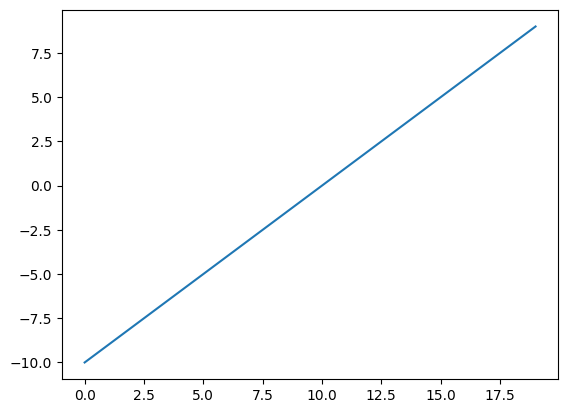

In [53]:
# Visualize the tensor
plt.plot(A)

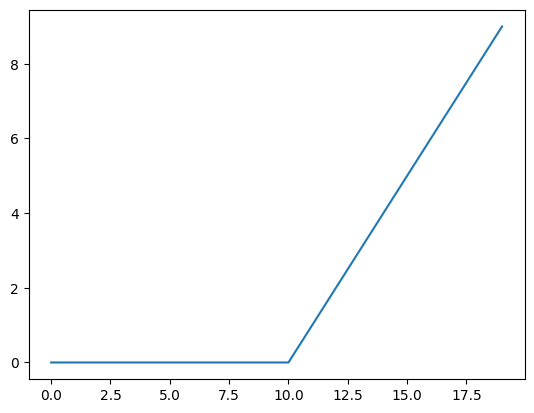

In [54]:
plt.plot(torch.relu(A))

In [55]:
def relu(x: torch.Tensor):
  return torch.maximum(torch.tensor(0), x) # inputs must be tensors

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

In [56]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

In [57]:
# Let's do the same for Sigmoid
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

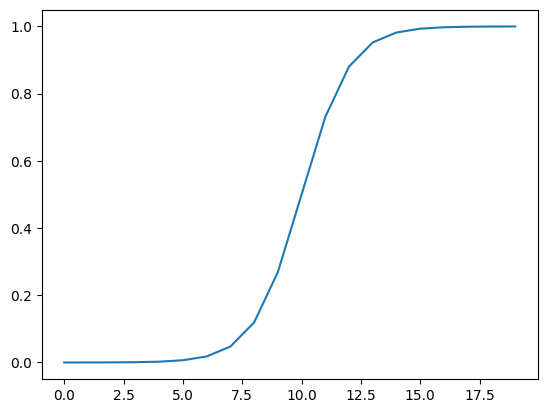

In [58]:
plt.plot(torch.sigmoid(A))

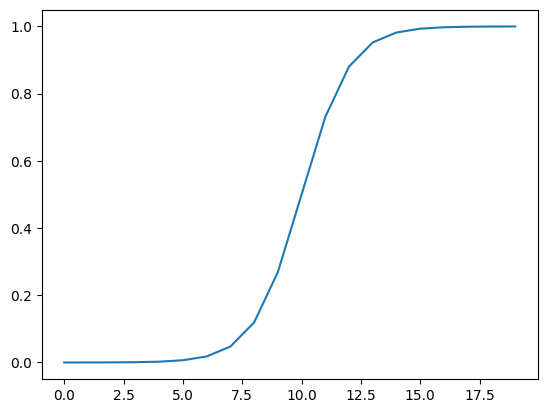

In [59]:
plt.plot(sigmoid(A))

## 8. Putting it All Together with a Multi-class Classification Problem

* Binary classification = one thing or another (cat vs dog, spam vs non-spam)
* Multi-class classification = more than one thing or another (cat vs dog vs chicken)

### 8.1 Creating a toy multi-class dataset

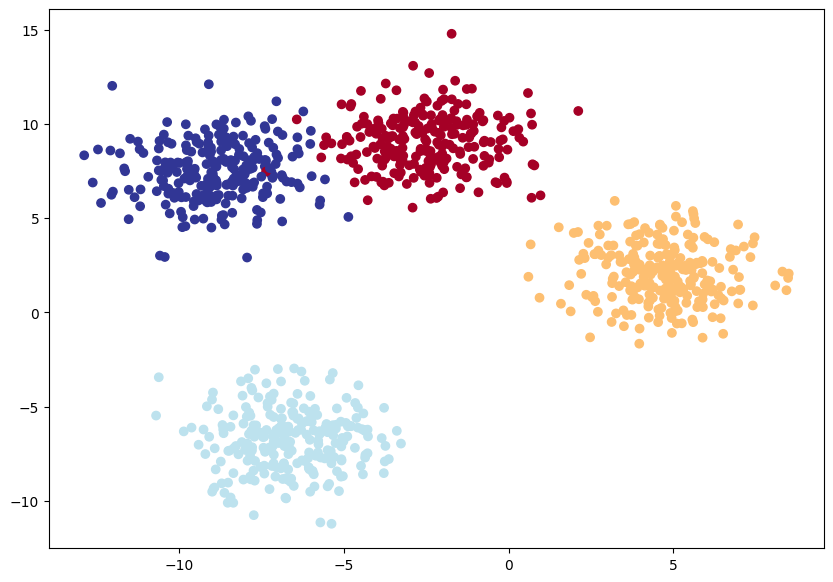

In [60]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multiclass data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features = NUM_FEATURES,
                            centers = NUM_CLASSES,
                            cluster_std=1.5, # give the clusters a little shake up
                            random_state = RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)
# 4. Plot data

plt.figure(figsize=(10,7))

plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

### 8.2 Building a Multi-class Classification Model in PyTorch

In [61]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [62]:
# Build a multi-class classification model

class BloblModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """
    Initializes multi-class classification model.

    Args:
    input_features (int): Number of input features to the model
    output_features (int): Number of output features (number of output classes)
    hidden_units (int): Number of hidden units between layers, default 8

    Returns:

    Example:
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self,x):
    return self.linear_layer_stack(x)

# Create an instance of BlobModel
model_4 = BloblModel(input_features=2,
                     output_features=4,
                     hidden_units=8).to(device)

model_4

BloblModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [63]:
torch.unique(y_blob_train) # That's why outfeatures = 4

tensor([0, 1, 2, 3])

### 8.3 Create a loss function and optimizer

In [64]:
# Create a loss function for multi-class classification - Loss function measures how wrong our model's predictions are
loss_fn = nn.CrossEntropyLoss()
# Create a optimizer - Optimizer updates our model parameters to try and reduce the loss
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

### 8.4 Getting prediction probabilities for a multi-class PyTorch Model

In order to evaluate and train and test our model, we need to convert our model's outputs to prediction probabilities and then to prediction labels.

Logits -> Pred Probs -> Pred Labels

In [65]:
# Let's get some row outputs of our model
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))
y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]])

In [66]:
# Convert our model's logit output to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]])
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]])


- 1 Row : 1
- 2 Row : 0
- 3 Row : 0

In [67]:
# Convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds


tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1])

In [68]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

### 8.5 Creating a training loop and testing loop for a multi-class PyTorch Model

In [69]:
# Fit the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.15883, Acc: 40.38% | Test Loss: 1.07554, Test Acc: 48.00%
Epoch: 10 | Loss: 0.64476, Acc: 96.75% | Test Loss: 0.66069, Test Acc: 97.50%
Epoch: 20 | Loss: 0.42535, Acc: 98.50% | Test Loss: 0.43074, Test Acc: 100.00%
Epoch: 30 | Loss: 0.25294, Acc: 99.12% | Test Loss: 0.24508, Test Acc: 99.50%
Epoch: 40 | Loss: 0.11232, Acc: 99.25% | Test Loss: 0.10229, Test Acc: 99.50%
Epoch: 50 | Loss: 0.06627, Acc: 99.25% | Test Loss: 0.05848, Test Acc: 99.50%
Epoch: 60 | Loss: 0.05068, Acc: 99.25% | Test Loss: 0.04293, Test Acc: 99.50%
Epoch: 70 | Loss: 0.04300, Acc: 99.25% | Test Loss: 0.03491, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03836, Acc: 99.25% | Test Loss: 0.02988, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03525, Acc: 99.25% | Test Loss: 0.02663, Test Acc: 99.50%


### 8.6 Making and evaluating predictiıns with a PyTorch Multi-class Model

In [70]:
# Make predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4 (X_blob_test)

y_logits[:10]

tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3761, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]])

In [71]:
# Go from logits -> Prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[1.3437e-03, 9.9865e-01, 1.2164e-06, 5.3854e-07],
        [4.9905e-03, 7.4740e-05, 1.0630e-03, 9.9387e-01],
        [1.3985e-03, 8.6060e-04, 9.9463e-01, 3.1073e-03],
        [4.7389e-03, 9.9483e-01, 3.1956e-04, 1.1353e-04],
        [9.9388e-01, 6.0966e-03, 2.4904e-06, 2.2378e-05],
        [1.3372e-03, 1.1504e-05, 3.0644e-04, 9.9834e-01],
        [2.9138e-03, 2.1537e-03, 9.8781e-01, 7.1181e-03],
        [9.9838e-01, 6.0198e-04, 3.4435e-05, 9.7989e-04],
        [2.8147e-04, 1.5016e-04, 9.9882e-01, 7.5044e-04],
        [9.9825e-01, 1.4575e-03, 1.5997e-05, 2.7210e-04]])

In [72]:
# Go from pred probs to pred labes
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

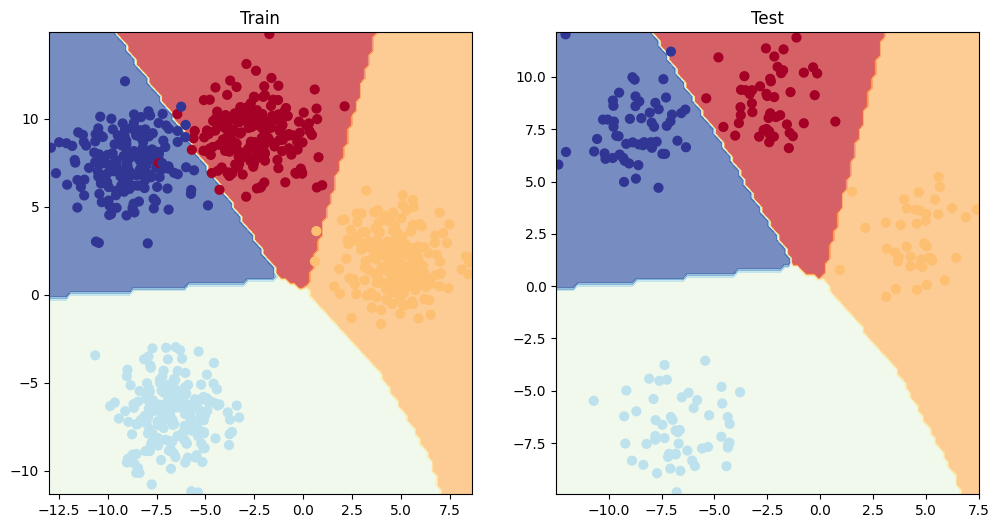

In [73]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. A few more classification metrics

* Accuracy - out of 100 samples how many does our model get right
* Precision
* Recall
* F1-Score
* Confusion Matrix
* Classification Report

In [74]:
!pip install torchmetrics

In [75]:
from torchmetrics import Accuracy

# Setup metric
torchmetric_accuracy = Accuracy(task="multiclass", num_classes=4).to(device)

# Calculate accuracy
torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.9950)

## 10. Exercises:

1- Make a binary classification dataset with Scikit-Learn's make_moons() function.

2- Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.

3- Setup a binary classification compatible loss function and optimizer to use when training the model built in 2.

4- Create a training and testing loop to fit the model you created in 2 to the data you created in 1.

5- Make predictions with your trained model and plot them using the plot_decision_boundary() function created in this notebook.


6- Create a multi-class dataset using the spirals data creation function from CS231n.
- Split the data into training and test sets (80% train, 20% test) as well as turn it into PyTorch tensors.
* Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
* Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
* Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like) - 1000 epochs should be plenty.
* Plot the decision boundaries on the spirals dataset from your model predictions, the plot_decision_boundary() function should work for this dataset too.



In [76]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

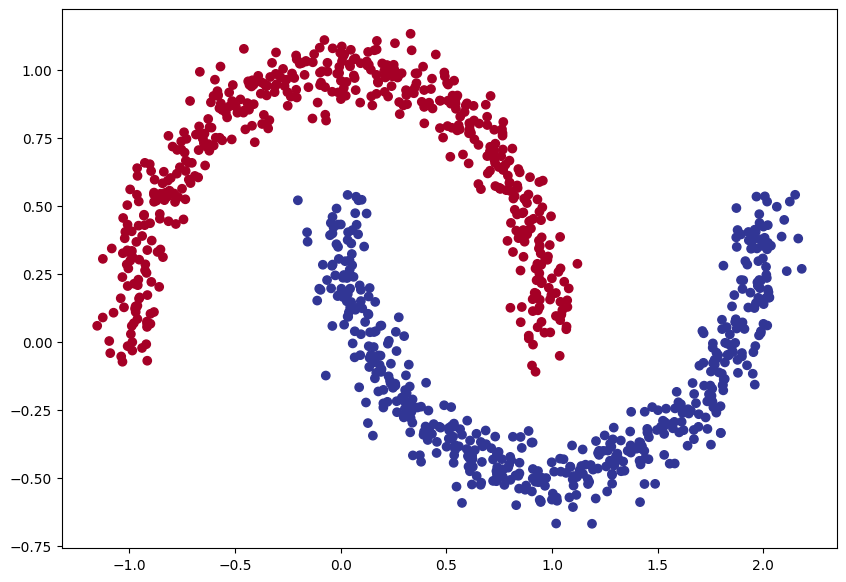

In [77]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

RANDOM_SEED = 42
NUM_SAMPLES = 1000

# Create dataset
X_moon, y_moon = make_moons(n_samples= NUM_SAMPLES,
                            noise = 0.07,
                            random_state= RANDOM_SEED)



# Plot the data
plt.figure(figsize=(10,7))

plt.scatter(X_moon[:,0], X_moon[:,1], c=y_moon, cmap=plt.cm.RdYlBu)


In [78]:
# Turn data into a tensor
X_moon = torch.from_numpy(X_moon).type(torch.float)
y_moon = torch.from_numpy(y_moon).type(torch.float)


# Split into train and test

X_moon_train, X_moon_test, y_moon_train, y_moon_test = train_test_split(X_moon,
                                                                        y_moon,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

In [79]:
len(X_moon_train), len(X_moon_test), len(y_moon_train), len(y_moon_test)

(800, 200, 800, 200)

In [80]:
# Create model
class MoonModelV0(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()

    self.linear_layer_stack = nn.Sequential(

        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
  )
  def forward(self,x):
    return self.linear_layer_stack(x)


model_5 = MoonModelV0(input_features=2,
                      output_features=1,
                      hidden_units=10)


In [81]:
model_5

MoonModelV0(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [82]:
# Setup loss function
loss_fn = nn.BCEWithLogitsLoss()
# Setup optimizer to optimize model's parameters
optimizer = torch.optim.SGD(params= model_5.parameters(),
                            lr= 0.01)

In [83]:
# logits (raw outputs of model)
print("Logits:")
print(model_5(X_moon_train.to(device)[:10]).squeeze())

# Prediction probabilities
print("Pred probs:")
print(torch.sigmoid(model_5(X_moon_train.to(device)[:10]).squeeze()))

# Prediction probabilities
print("Pred labels:")
print(torch.round(torch.sigmoid(model_5(X_moon_train.to(device)[:10]).squeeze())))

Logits:
tensor([0.1624, 0.2075, 0.2037, 0.2031, 0.2111, 0.2058, 0.2113, 0.2113, 0.1882,
        0.2093], grad_fn=<SqueezeBackward0>)
Pred probs:
tensor([0.5405, 0.5517, 0.5507, 0.5506, 0.5526, 0.5513, 0.5526, 0.5526, 0.5469,
        0.5521], grad_fn=<SigmoidBackward0>)
Pred labels:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], grad_fn=<RoundBackward0>)


In [84]:
from torchmetrics import Accuracy

acc_fn = Accuracy(task="multiclass", num_classes=2).to(device)
acc_fn

MulticlassAccuracy()

In [85]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

# Epochs
epochs = 4000

# Setup data to target device
X_moon_train, y_moon_train = X_moon_train.to(device), y_moon_train.to(device)
X_moon_test, y_moon_test = X_moon_test.to(device), y_moon_test.to(device)

# Loop
for epoch in range(epochs):
  ### Training
  model_5.train()

  # Forward pass
  y_logits = model_5(X_moon_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  # Calculate loss
  loss = loss_fn(y_logits, y_moon_train)
  acc = acc_fn(y_pred,y_moon_train.int())
  # Optimizer zero grad
  optimizer.zero_grad()
  # Loss backward
  loss.backward()
  # Optimzer step
  optimizer.step()

  ### Testing
  model_5.eval()
  with torch.inference_mode():
    test_logits = model_5(X_moon_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_moon_test)
    test_acc = acc_fn(test_preds,y_moon_test.int())

  if epoch %500==0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.6981, Acc: 0.50% | Test Loss: 0.6973, Acc: 0.50%
Epoch: 500 | Loss: 0.6780, Acc: 0.54% | Test Loss: 0.6780, Acc: 0.55%
Epoch: 1000 | Loss: 0.6006, Acc: 0.81% | Test Loss: 0.6038, Acc: 0.79%
Epoch: 1500 | Loss: 0.3585, Acc: 0.84% | Test Loss: 0.3675, Acc: 0.80%
Epoch: 2000 | Loss: 0.2507, Acc: 0.89% | Test Loss: 0.2482, Acc: 0.89%
Epoch: 2500 | Loss: 0.2034, Acc: 0.92% | Test Loss: 0.1930, Acc: 0.94%
Epoch: 3000 | Loss: 0.1610, Acc: 0.94% | Test Loss: 0.1483, Acc: 0.95%
Epoch: 3500 | Loss: 0.1125, Acc: 0.96% | Test Loss: 0.1003, Acc: 0.98%


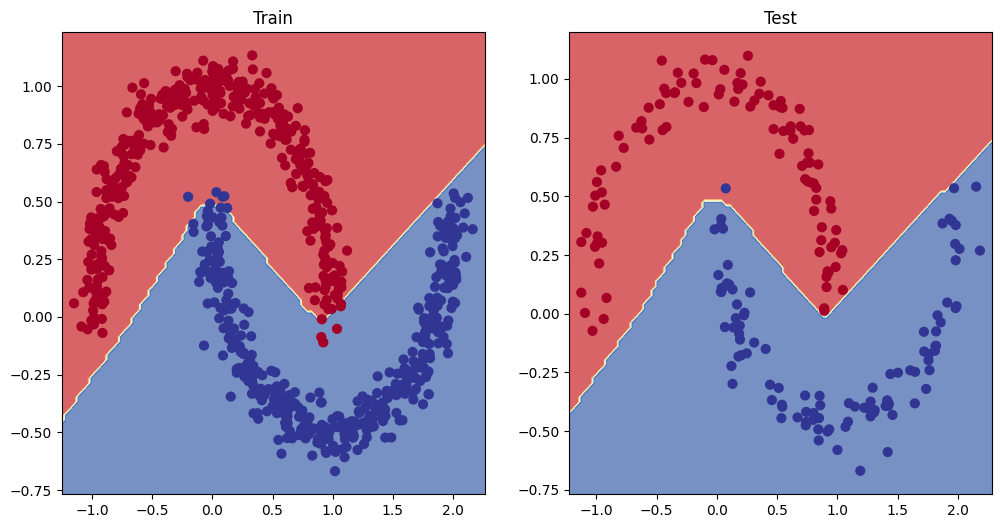

In [86]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_5, X_moon_train, y_moon_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_5, X_moon_test, y_moon_test)

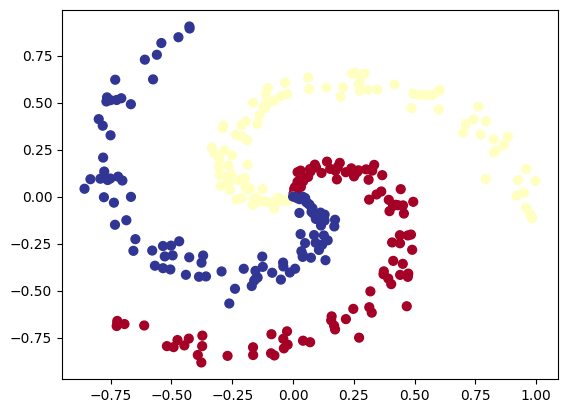

In [88]:
import numpy as np
# Code for creating a spiral dataset from CS231n
np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [89]:
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor)

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2, random_state=RANDOM_SEED )



In [91]:
len(X_train), len(X_test), len(y_train), len(y_test)

(240, 60, 240, 60)

In [92]:
class CS(nn.Module):
  def __init__(self, in_features, out_features, hidden_units=10):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=in_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=out_features)
      )
  def forward(self,x):
    return self.linear_layer_stack(x)


In [93]:
model_6 = CS(in_features=2, out_features=3,hidden_units=10)

In [94]:
model_6

CS(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [95]:
# Create a loss function
loss_fn = nn.CrossEntropyLoss()
# Create a optimizer
optimizer = torch.optim.Adam(params=model_6.parameters(),
                            lr=0.02)

In [96]:
# logits (raw outputs of model)
print("Logits:")
print(model_5(X_moon_train.to(device)[:10]).squeeze())

# Prediction probabilities
print("Pred probs:")
print(torch.sigmoid(model_5(X_moon_train.to(device)[:10]).squeeze()))

# Prediction probabilities
print("Pred labels:")
print(torch.round(torch.sigmoid(model_5(X_moon_train.to(device)[:10]).squeeze())))

Logits:
tensor([ 3.7997, -4.0286, -5.1647, -4.5786,  3.6495, -3.8329,  3.5001,  2.6972,
        -4.7812, -2.2890], grad_fn=<SqueezeBackward0>)
Pred probs:
tensor([0.9781, 0.0175, 0.0057, 0.0102, 0.9747, 0.0212, 0.9707, 0.9369, 0.0083,
        0.0920], grad_fn=<SigmoidBackward0>)
Pred labels:
tensor([1., 0., 0., 0., 1., 0., 1., 1., 0., 0.], grad_fn=<RoundBackward0>)


In [97]:
acc_fn = Accuracy(task="multiclass", num_classes=3).to(device) # send accuracy function to device
acc_fn

MulticlassAccuracy()

In [98]:
# Fit the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 1000

# Data to target device
#X_train, y_train = X_train.to(device), y_train(device)
#X_test, y_test = X_test.to(device), y_test(device)

for epoch in range(epochs):
  model_6.train()

  y_logits = model_6(X_train)
  y_pred =torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss=loss_fn(y_logits, y_train)
  acc= acc_fn(y_train, y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  ## Testing
  model_6.eval()
  with torch.inference_mode():
    test_logits = model_6(X_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits,y_test)
    test_acc = acc_fn(y_test, test_preds)

  if epoch % 100==0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.10360, Acc: 0.32% | Test Loss: 1.09121, Test Acc: 0.37%
Epoch: 100 | Loss: 0.44825, Acc: 0.74% | Test Loss: 0.48083, Test Acc: 0.70%
Epoch: 200 | Loss: 0.16160, Acc: 0.95% | Test Loss: 0.12357, Test Acc: 0.97%
Epoch: 300 | Loss: 0.03421, Acc: 0.99% | Test Loss: 0.00927, Test Acc: 1.00%
Epoch: 400 | Loss: 0.02214, Acc: 0.99% | Test Loss: 0.00416, Test Acc: 1.00%
Epoch: 500 | Loss: 0.02868, Acc: 0.99% | Test Loss: 0.00339, Test Acc: 1.00%
Epoch: 600 | Loss: 0.01743, Acc: 0.99% | Test Loss: 0.00097, Test Acc: 1.00%
Epoch: 700 | Loss: 0.01641, Acc: 0.99% | Test Loss: 0.00152, Test Acc: 1.00%
Epoch: 800 | Loss: 0.01573, Acc: 0.99% | Test Loss: 0.00161, Test Acc: 1.00%
Epoch: 900 | Loss: 0.01526, Acc: 0.99% | Test Loss: 0.00166, Test Acc: 1.00%


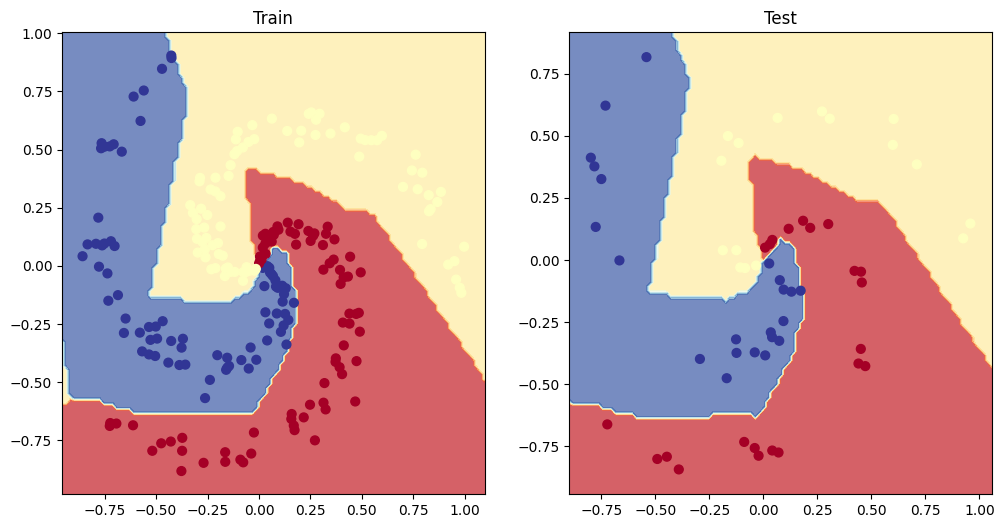

In [99]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_6, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_6, X_test, y_test)